# 1. Introduction
The dataset used in this project includes data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. The data contains 17 attributes and 2111 records, the records are labeled with the class variable NObesity (Obesity Level), that allows classification of the data using the values of Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.

The data and complete information about the variables is available in: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

The objective of this notebook is to show how to develop a model to predict obesity. The first model predicts presence or absence of obesity, which includes every level after Normal Weight, and the second model predicts the specific level.

# 2. Import required libraries
Import necessary libraries such as pandas, matplotlib, seaborn, and scipy for running the code.

In [1]:
import pandas as pd
import plotnine as pn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, GridSearchCV, validation_curve
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

%matplotlib inline

# 3. Data pre-processing
Load and pre-process the dataset.

In [2]:
# https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

# Load the dataset
data = 'Data/RawData.csv'

# Read the dataset
data = pd.read_csv(data)
data.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
# Identify missing values
data.isnull().sum()
print(data.isnull().sum())

# Shape of the dataset
data.shape
print(data.shape)

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
(2111, 17)


In [4]:
# Transform all the categorical x variables into numerical variables

# Transform 'Gender' column to numerical values, Female 0 and Male 1
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
# Check the transformation
print(data['Gender'].head())

# Transform binary columns to numerical values (yes = 1, no = 0)
columns_to_transform = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
for column in columns_to_transform:
    data[column] = data[column].map({'yes': 1, 'no': 0})
# Check the transformation
print(data[columns_to_transform].head())


# Transform 'CAEC' column to numerical values
data['CAEC'] = data['CAEC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
# Check the transformation
print(data['CAEC'].head())
# Transform 'CALC' column to numerical values
data['CALC'] = data['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
# Check the transformation
print(data['CALC'].head())
# Transform 'MTRANS' column to numerical values
data['MTRANS'] = data['MTRANS'].map({'Public_Transportation': 1, 'Walking' : 2, 'Automobile': 3, 'Motorbike': 4, 'Bike': 5})
# Check the transformation
print(data['MTRANS'].head())



0    0
1    0
2    1
3    1
4    1
Name: Gender, dtype: int64
   family_history_with_overweight  FAVC  SMOKE  SCC
0                               1     0      0    0
1                               1     0      1    1
2                               1     0      0    0
3                               0     0      0    0
4                               0     0      0    0
0    1
1    1
2    1
3    1
4    1
Name: CAEC, dtype: int64
0    0
1    1
2    2
3    2
4    1
Name: CALC, dtype: int64
0    1
1    1
2    1
3    2
4    1
Name: MTRANS, dtype: int64


In [5]:
# Transform 'NObeyesdad' column to numerical values Overweight = 1, No_Overweight = 0
data['Overweight'] = data['NObeyesdad'].map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 0,
    'Overweight_Level_I': 1,
    'Overweight_Level_II': 1,
    'Obesity_Type_I': 1,
    'Obesity_Type_II': 1,
    'Obesity_Type_III': 1
})

# Check the transformation
print(data[['NObeyesdad', 'Overweight']].head())

            NObeyesdad  Overweight
0        Normal_Weight           0
1        Normal_Weight           0
2        Normal_Weight           0
3   Overweight_Level_I           1
4  Overweight_Level_II           1


In [6]:
# Statistical description of the DataFrame
data.describe()
print(data.describe())

            Gender          Age       Height       Weight  \
count  2111.000000  2111.000000  2111.000000  2111.000000   
mean      0.505921    24.312600     1.701677    86.586058   
std       0.500083     6.345968     0.093305    26.191172   
min       0.000000    14.000000     1.450000    39.000000   
25%       0.000000    19.947192     1.630000    65.473343   
50%       1.000000    22.777890     1.700499    83.000000   
75%       1.000000    26.000000     1.768464   107.430682   
max       1.000000    61.000000     1.980000   173.000000   

       family_history_with_overweight         FAVC         FCVC          NCP  \
count                     2111.000000  2111.000000  2111.000000  2111.000000   
mean                         0.817622     0.883941     2.419043     2.685628   
std                          0.386247     0.320371     0.533927     0.778039   
min                          0.000000     0.000000     1.000000     1.000000   
25%                          1.000000     1.000000

# 4.1 Model setup 1
Set up a model to predict whether a person is overweight or not. 

In [7]:
# Setup train/test data

# Get the y values and drop from df
y= data.Overweight
# Drop the y column from the DataFrame
X= data.drop(columns=['Overweight', 'NObeyesdad'])

# Split to 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the data in x_train and x_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Create and fit a model using our data
model = Pipeline([
    ('logistic', LogisticRegression(solver='liblinear'))
     ])     
model.fit(X_train,y_train)

Pipeline(steps=[('logistic', LogisticRegression(solver='liblinear'))])

In [9]:
# Mean Squared Error
def mse(model, x, y): 
    return np.mean((y-model.predict(x))**2)

print('R^2:', model.score(X_train, y_train), 'MSE:', mse(model, X_train, y_train))

R^2: 0.9842072015161086 MSE: 0.015792798483891344


# 4.2 Hyperparameter tuning
Do some playing with the model hyperparameters (learning rate, optimizer, batch size, epochs, whatever makes sense)

In [10]:
# Define the base model
logistic = LogisticRegression(solver='liblinear')

# Define the hyperparameters you want to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse regularization strength (higher values = less regularization)
    'penalty': ['l1', 'l2']  # Type of regularization
}

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

# Use the best model found
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'C': 10, 'penalty': 'l1'}
Best accuracy: 0.9943197699956077


# 4.3 Results


### Test the model without hyperparameter tuning

Model score on training data: 0.9842072015161086
Model score on testing data: 0.9810606060606061


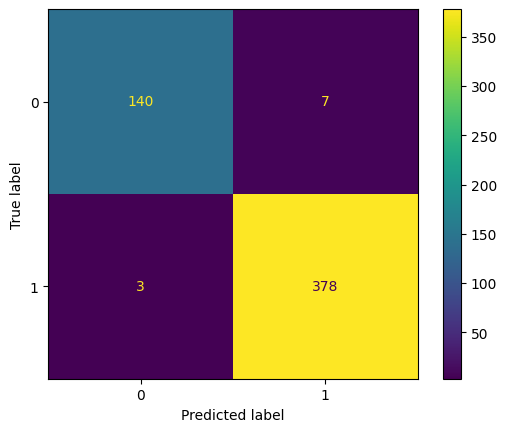

In [11]:
# Predict ys using model and test data
y_pred = model.predict(X_test)

# Get model.score for both training and test data
print(f'Model score on training data: {model.score(X_train, y_train)}')
print(f'Model score on testing data: {model.score(X_test, y_test)}')

# Print the confusion matrix on the test data
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred), display_labels=model['logistic'].classes_).plot()

In [12]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       147
           1       0.98      0.99      0.99       381

    accuracy                           0.98       528
   macro avg       0.98      0.97      0.98       528
weighted avg       0.98      0.98      0.98       528



In [13]:
print(model['logistic'].coef_)

# odds = exp(coef_)
odds = np.exp(model['logistic'].coef_)

# Create a dataframe and sort by odds column with highest at top
pd.DataFrame(np.transpose(odds), X.columns, columns=['odds']).sort_values(by='odds', ascending=False)

[[-1.53558704e-01  3.17182825e-01 -2.26160554e+00  7.81872798e+00
   2.89568190e-01  2.31695779e-01 -1.10200848e-01  1.67356901e-03
  -5.80231048e-01 -1.53042117e-01  1.16953998e-01  1.49855292e-01
  -1.87456525e-01  6.84910898e-02  6.69596648e-02 -6.12275216e-02]]


,odds
Weight,2486.740210
Age,1.373254
family_history_with_overweight,1.335851
FAVC,1.260736
SCC,1.161666
CH2O,1.124068
TUE,1.070891
CALC,1.069252
NCP,1.001675
MTRANS,0.940609


### Test the model after hyperparameter tuning

Model score on training data: 0.9987365761212887
Model score on testing data: 0.9943181818181818


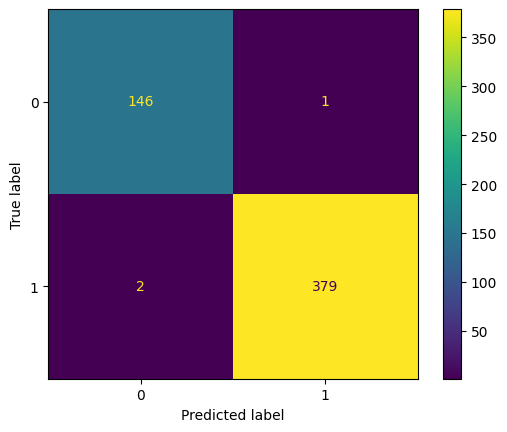

In [14]:
# Predict ys using best_model and test data
y_pred2 = best_model.predict(X_test)

# Get model.score for both training and test data for best_model
print(f'Model score on training data: {best_model.score(X_train, y_train)}')
print(f'Model score on testing data: {best_model.score(X_test, y_test)}')

# Print the confusion matrix on the test data
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred2), display_labels=model['logistic'].classes_).plot()

In [15]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       1.00      0.99      1.00       381

    accuracy                           0.99       528
   macro avg       0.99      0.99      0.99       528
weighted avg       0.99      0.99      0.99       528



In [16]:
print(best_model.coef_)

# odds = exp(coef_)
odds = np.exp(best_model.coef_)

# Create a dataframe and sort by odds column with highest at top
pd.DataFrame(np.transpose(odds), X.columns, columns=['odds']).sort_values(by='odds', ascending=False)

[[ -1.22229774   0.30091495 -15.7386687   53.26887484  -0.06464862
    0.55430894  -0.44065226  -0.14598538  -0.90452217  -0.69347739
   -0.18357494   0.71145824  -0.71767468   0.53152445  -0.27815859
    0.10671901]]


,odds
Weight,1.362631e+23
SCC,2.036959e+00
FAVC,1.740738e+00
TUE,1.701524e+00
Age,1.351094e+00
MTRANS,1.112622e+00
family_history_with_overweight,9.373968e-01
NCP,8.641703e-01
CH2O,8.322895e-01
CALC,7.571767e-01


### Use the best_model to make a prediction.

In [17]:
# Create a dataset with data that matches the model's expected features
data_subject1 = pd.DataFrame({
    'Gender': [0],  # 1 for Male, 0 for Female
    'Age': [37],  # Age in years
    'Height': [1.73],  # Height in meters
    'Weight': [121.3],  # Weight in kilograms
    'family_history_with_overweight': [1],  # 1 for yes, 0 for no
    'FAVC': [1],  # Eat high caloric food: 1 for yes, 0 for no
    'FCVC': [1],  # Frequency for vegetables consumption: Never = 1, Sometimes = 2, Always = 3    
    'NCP': [3],  # Daily number of meals: Between 1-2 = 1, Three = 2, More than three = 3
    'CAEC': [1],  # Frequency for eating between meals: No = 0, Sometimes = 1, Frequently = 2, Always = 3
    'SMOKE': [1],  # 1 for yes, 0 for no
    'CH2O': [2],  # Water consumption: < 1 Liter = 1, 1-2 Liters = 2, > 2 Liters = 3
    'SCC': [0],  # Monitor calories: 1 for yes, 0 for no
    'FAF': [0],  # Frequency for physical activity: Do not do any = 0, 1-2 times/week = 1, 3-4 times/week = 2, > 4 times/week = 3
    'TUE': [2],  # Time spent on technological devices: < 2 hours = 0, 2-5 hours = 1, > 5 hours = 2
    'CALC': [0],  # Frequency for alcohol consumption: Do not drink = 0, Sometimes = 1, Frequently = 2, Always = 3
    'MTRANS': [1]  # Transportation mode: Public_Transportation = 1, Walking = 2, Automobile = 3, Motorbike = 4, Bike = 5
})

# Ensure the data is scaled using the same scaler as the training data
data_subject1 = scaler.transform(data_subject1)

# Predict using the trained model
prediction = best_model.predict(data_subject1)

# Display the prediction
print(f"Prediction for subject 1: {prediction}")

Prediction for subject 1: [1]


# 5.1 Model setup 2
Set up a model to predict the level of weight of a person.

In [18]:
# Transform 'NObeyesdad' column to numerical values and create a new column 'WeightLevel'
data['WeightLevel'] = data['NObeyesdad'].map({
    'Insufficient_Weight': 1,
    'Normal_Weight': 2,
    'Overweight_Level_I': 3,
    'Overweight_Level_II': 4,
    'Obesity_Type_I': 5,
    'Obesity_Type_II': 6,
    'Obesity_Type_III': 7
})

# Check the transformation
print(data[['NObeyesdad', 'WeightLevel']].head())

            NObeyesdad  WeightLevel
0        Normal_Weight            2
1        Normal_Weight            2
2        Normal_Weight            2
3   Overweight_Level_I            3
4  Overweight_Level_II            4


In [19]:
# Setup train/test data

# Get the y values and drop from df
y= data.WeightLevel
# Drop the y column from the DataFrame
X= data.drop(columns=['WeightLevel', 'Overweight', 'NObeyesdad'])

# Split to 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the data in x_train and x_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Create and fit a model using our data
model = Pipeline([
    ('logistic', LogisticRegression(solver='liblinear'))
     ])     
model.fit(X_train,y_train)

Pipeline(steps=[('logistic', LogisticRegression(solver='liblinear'))])

In [21]:
# Mean Squared Error
def mse(model, x, y): 
    return np.mean((y-model.predict(x))**2)

print('R^2:', model.score(X_train, y_train), 'MSE:', mse(model, X_train, y_train))

R^2: 0.7687934301958307 MSE: 0.4478837650031586


# 5.2 Hyperparameter tuning
Do some playing with the model hyperparameters (learning rate, optimizer, batch size, epochs, whatever makes sense)

In [22]:
# Define the base model
logistic = LogisticRegression(solver='liblinear')

# Define the hyperparameters you want to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse regularization strength (higher values = less regularization)
    'penalty': ['l1', 'l2']  # Type of regularization
}

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

# Use the best model found
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


Best hyperparameters: {'C': 100, 'penalty': 'l1'}
Best accuracy: 0.7795252166274009


/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


In [65]:
#Define the model 

SVM =Pipeline([ 
   ('SVC', SVC(kernel='linear', C=1E10))
])
SVM.fit(X_train, y_train)

# Predict the test set
y_SVM = SVM.predict(X_test)

: 

: 

# 5.3 Results


### Test the model without hyperparameter tuning

Model score on training data: 0.7687934301958307
Model score on testing data: 0.7803030303030303


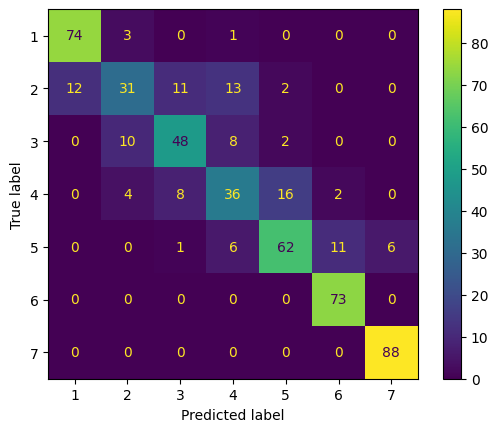

In [23]:
# Predict ys using model and test data
y_pred = model.predict(X_test)

# Get model.score for both training and test data
print(f'Model score on training data: {model.score(X_train, y_train)}')
print(f'Model score on testing data: {model.score(X_test, y_test)}')

# Print the confusion matrix on the test data
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred), display_labels=model['logistic'].classes_).plot()

In [24]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.86      0.95      0.90        78
           2       0.65      0.45      0.53        69
           3       0.71      0.71      0.71        68
           4       0.56      0.55      0.55        66
           5       0.76      0.72      0.74        86
           6       0.85      1.00      0.92        73
           7       0.94      1.00      0.97        88

    accuracy                           0.78       528
   macro avg       0.76      0.77      0.76       528
weighted avg       0.77      0.78      0.77       528



### Test the model after hyperparameter tuning

Model score on training data: 0.799115603284902
Model score on testing data: 0.8011363636363636


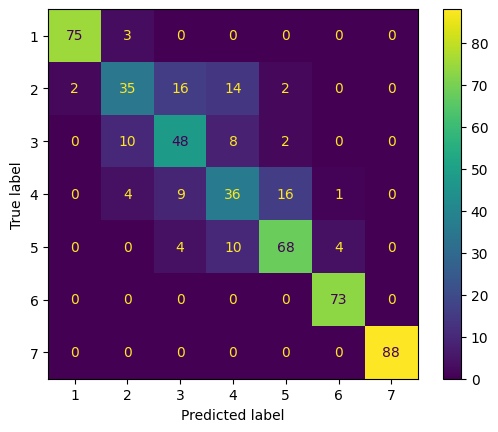

In [25]:
# Predict ys using best_model and test data
y_pred2 = best_model.predict(X_test)

# Get model.score for both training and test data for best_model
print(f'Model score on training data: {best_model.score(X_train, y_train)}')
print(f'Model score on testing data: {best_model.score(X_test, y_test)}')

# Print the confusion matrix on the test data
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred2), display_labels=model['logistic'].classes_).plot()

In [26]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.97      0.96      0.97        78
           2       0.67      0.51      0.58        69
           3       0.62      0.71      0.66        68
           4       0.53      0.55      0.54        66
           5       0.77      0.79      0.78        86
           6       0.94      1.00      0.97        73
           7       1.00      1.00      1.00        88

    accuracy                           0.80       528
   macro avg       0.79      0.79      0.78       528
weighted avg       0.80      0.80      0.80       528



In [27]:
# Create a dataset with data that matches the model's expected features
data_subject2 = pd.DataFrame({
    'Gender': [0],  # 1 for Male, 0 for Female
    'Age': [37],  # Age in years
    'Height': [1.73],  # Height in meters
    'Weight': [121.3],  # Weight in kilograms
    'family_history_with_overweight': [1],  # 1 for yes, 0 for no
    'FAVC': [1],  # Eat high caloric food: 1 for yes, 0 for no
    'FCVC': [1],  # Frequency for vegetables consumption: Never = 1, Sometimes = 2, Always = 3    
    'NCP': [3],  # Daily number of meals: Between 1-2 = 1, Three = 2, More than three = 3
    'CAEC': [1],  # Frequency for eating between meals: No = 0, Sometimes = 1, Frequently = 2, Always = 3
    'SMOKE': [1],  # 1 for yes, 0 for no
    'CH2O': [2],  # Water consumption: < 1 Liter = 1, 1-2 Liters = 2, > 2 Liters = 3
    'SCC': [0],  # Monitor calories: 1 for yes, 0 for no
    'FAF': [0],  # Frequency for physical activity: Do not do any = 0, 1-2 times/week = 1, 3-4 times/week = 2, > 4 times/week = 3
    'TUE': [2],  # Time spent on technological devices: < 2 hours = 0, 2-5 hours = 1, > 5 hours = 2
    'CALC': [0],  # Frequency for alcohol consumption: Do not drink = 0, Sometimes = 1, Frequently = 2, Always = 3
    'MTRANS': [1]  # Transportation mode: Public_Transportation = 1, Walking = 2, Automobile = 3, Motorbike = 4, Bike = 5
})

# Ensure the data is scaled using the same scaler as the training data
data_subject2 = scaler.transform(data_subject2)

# Predict using the trained model
prediction = best_model.predict(data_subject2)

# Display the prediction
print(f"Prediction for subject 2: {prediction}")

Prediction for subject 2: [5]


# 6. Discussion
Summarize what worked, what didn't etc.